# Food 101 Challenge

Author: Felipe C. de Pauli
Date: 20/11/2023

This challenge was made in four steps:

1. A simple walk through the data, creating a binary classification with pizza and steak classes;
2. Create a multiclass classification with 10 classes and adjust hyperparameters;
3. Create the final notebook with all 101 classes and test the execution;
4. Create the final python program to run in a computer with GPU.

# Part 1: Binary Classification

Let's build a convolutional neural network to find patterns in our images, more specifically we need a way to:

1. Load and learn about our images
2. Preprocess the images
3. Build a CNN to find patterns in our images
4. Compile our CNN
5. Fit the CNN to our training data
6. Evaluate the model and restart the process

In [1]:
import numpy as np
import os
import tensorflow as tf

2023-11-22 13:39:47.317867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's look if there is a GPU available to use (if you are using the colab, you have to enable the GPU on notebook settings).

In [3]:
print("Available GPUs: ", tf.config.list_physical_devices('GPU'))

Available GPUs:  []


# 1. Load and learn about our images

## Get the data

First of all, we have to get the data and prepare it.

Ps.: I found another place to get the data wihtout the need to get a key.

In [5]:
# Getting data from ztm (a Deep Learning Course's Plataform)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_fd = zipfile.ZipFile("pizza_steak.zip")
zip_fd.extractall()
zip_fd.close()

--2023-11-22 13:40:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.128.123, 142.250.219.59, 142.251.129.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.128.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  10.0MB/s    in 11s     

2023-11-22 13:40:51 (9.69 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## Inspect the Data (become one with it)

In [6]:
!ls pizza_steak

test  train


In [7]:
!ls pizza_steak/train

pizza  steak


In [8]:
!ls pizza_steak/test/pizza

1001116.jpg  1507019.jpg  2242047.jpg  2944567.jpg  3669673.jpg  556507.jpg
1032754.jpg  1512557.jpg  22489.jpg    296426.jpg   3724187.jpg  565112.jpg
103708.jpg   153195.jpg   2250611.jpg  2971095.jpg  3724353.jpg  573054.jpg
1060407.jpg  1555015.jpg  226472.jpg   2992605.jpg  3724416.jpg  614236.jpg
106507.jpg   1594097.jpg  2265512.jpg  2997525.jpg  3728155.jpg  614981.jpg
1067986.jpg  1618659.jpg  2276783.jpg  300157.jpg   3729167.jpg  61656.jpg
1106738.jpg  1636919.jpg  2296393.jpg  3042459.jpg  373847.jpg	 625434.jpg
1119571.jpg  1655630.jpg  2320458.jpg  3049449.jpg  3754474.jpg  645087.jpg
11297.jpg    1686938.jpg  2323860.jpg  3092704.jpg  3758160.jpg  648055.jpg
1152100.jpg  1687143.jpg  2343304.jpg  309892.jpg   376625.jpg	 65128.jpg
1179703.jpg  1691503.jpg  2392727.jpg  3174637.jpg  3770514.jpg  666569.jpg
1180001.jpg  1694874.jpg  2398925.jpg  321526.jpg   3784357.jpg  678708.jpg
1180273.jpg  1765727.jpg  2406842.jpg  3216107.jpg  3785667.jpg  714866.jpg
1183595.jpg  177

Inside the pizza_steak directory, we have all images of pizzas and steaks from Food-101. We will begin with this simpler case.

We got the following directories with images
* pizza_steak/train/pizza
* pizza_steak/test/pizza
* pizza_steak/train/steak
* pizza_steak/test/steak

In [9]:
import os

for dirpath, dirname, filename in os.walk("pizza_steak"):
    if (len(filename) == 0):
        continue
    if (len(dirpath) > 0):
        print(">>", dirpath)
    if (len(filename) > 0):
        print("   images: ", len(filename))

>> pizza_steak/test/steak
   images:  250
>> pizza_steak/test/pizza
   images:  250
>> pizza_steak/train/steak
   images:  750
>> pizza_steak/train/pizza
   images:  750


We need the name of the classes used. This is very easy now, but when we are working with 101, that way to get it will be very useful.

In [10]:
import pathlib
import numpy as np

# Generate the Path object data_dir
data_dir = pathlib.Path("pizza_steak/train")

# Get from Path object all the names os each file inside this directory
classes = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(classes)

['pizza' 'steak']


In [11]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['1205154.jpg']
Image shape: (512, 512, 3)


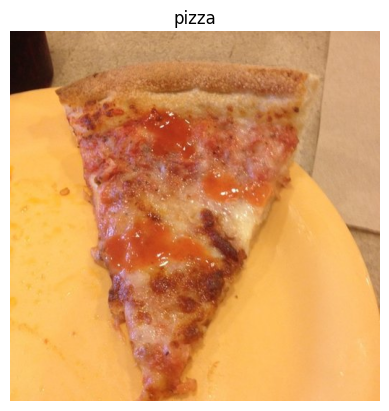

In [12]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [13]:
# Ok. We've used the mpimg to get an image from our computer and plot it using matplotlib.
# Matplotlib plots images using the RGB system. Then you have to give to it
# an image of (cols, rows, channels)
print(type(img))
print(img.shape)

# But to work with tensoflow, we need a tensor. A tensor is a structured that
# stores descriptions of objects. A vector is a tensor, but we can have strucutures
# more complex than a vector to describe an object, and it could be using a tensor.
# We need to cast img as a tensor.
tf.constant(img)

<class 'numpy.ndarray'>
(512, 512, 3)


<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 22,  12,  11],
        [ 22,  12,  11],
        [ 22,  10,  10],
        ...,
        [208, 160, 122],
        [209, 161, 123],
        [210, 162, 124]],

       [[ 21,  11,  10],
        [ 20,  10,   9],
        [ 21,   9,   9],
        ...,
        [208, 160, 122],
        [208, 160, 122],
        [208, 160, 122]],

       [[ 21,  11,  10],
        [ 20,  10,   9],
        [ 20,   8,   8],
        ...,
        [208, 160, 122],
        [207, 159, 121],
        [206, 158, 120]],

       ...,

       [[253, 188,  88],
        [253, 188,  88],
        [253, 189,  89],
        ...,
        [252, 180,  95],
        [252, 180,  95],
        [252, 180,  95]],

       [[253, 188,  88],
        [253, 188,  88],
        [254, 189,  89],
        ...,
        [251, 179,  94],
        [251, 179,  94],
        [251, 179,  94]],

       [[253, 188,  88],
        [253, 188,  88],
        [254, 189,  89],
        ...,
        [251, 179,  9

The image is a huge tensor with 3 channel per pixel. The number of columns and rows could vary. That's not good for a neural network's input.

In [14]:
img.shape

(512, 512, 3)

# 2. Preprocess images

In [15]:
train_data_path = "./pizza_steak/train"
test_data_path  = "./pizza_steak/test"

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen  = ImageDataGenerator(rescale=1/255.)

train_data = train_data_gen.flow_from_directory(
    directory   = train_data_path,
    batch_size  = 32,
    target_size = (224, 224),
    seed        = 42,
    class_mode  = "binary"
)

test_data  = test_data_gen.flow_from_directory(
    directory   = test_data_path,
    batch_size  = 32,
    target_size = (224, 224),
    seed        = 42,
    class_mode  = "binary"
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


# 3. Build a CNN to find patterns in our images

We got the train_data and the test_data ready to cnn input. Now let's create our CNN!

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

In [18]:
# Create the architecture
model_1 = Sequential([
    Conv2D(
        filters     = 10,
        kernel_size = (3, 3),
        activation  = "relu",
        input_shape = (224, 224, 3)
    ),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(
        pool_size   = 2,
        padding     = "valid"
    ),

    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),

    Flatten(),

    Dense(1, activation = "sigmoid")
])

# 4. Compile our CNN

In [19]:
# Compile it with important hyperparameters
model_1.compile(
    optimizer   = tf.keras.optimizers.Adam(),
    metrics     = ["accuracy"],
    loss        = "binary_crossentropy"
)

# 5. Fit the CNN to our training data

In [52]:
# Time to train
history_1 = model_1.fit(
    train_data,
    epochs           = 10,
    steps_per_epoch  = len(train_data),
    validation_data  = test_data,
    validation_steps = len(test_data)
)

Epoch 1/10


47/47 [==============================] - 63s 1s/step - loss: 0.4261 - accuracy: 0.8080 - val_loss: 0.3830 - val_accuracy: 0.8600
Epoch 2/10
47/47 [==============================] - 63s 1s/step - loss: 0.3811 - accuracy: 0.8340 - val_loss: 0.3388 - val_accuracy: 0.8620
Epoch 3/10
47/47 [==============================] - 61s 1s/step - loss: 0.3243 - accuracy: 0.8687 - val_loss: 0.3901 - val_accuracy: 0.8220
Epoch 4/10
47/47 [==============================] - 64s 1s/step - loss: 0.2454 - accuracy: 0.9087 - val_loss: 0.4533 - val_accuracy: 0.8020
Epoch 5/10
47/47 [==============================] - 61s 1s/step - loss: 0.1710 - accuracy: 0.9367 - val_loss: 0.4061 - val_accuracy: 0.8380
Epoch 6/10
47/47 [==============================] - 63s 1s/step - loss: 0.0962 - accuracy: 0.9633 - val_loss: 0.5052 - val_accuracy: 0.8220
Epoch 7/10
47/47 [==============================] - 63s 1s/step - loss: 0.0472 - accuracy: 0.9900 - val_loss: 0.6546 - val_accuracy: 0.7940
Epoch 8/10
47/47 [=============

We got a good accuracy (training and test sets).

# 6. Evaluate the model

In [53]:
# Create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(filename=None, url=None, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it
  to (img_shape, img_shape, colour_channels).
  """

  if url is not None:
    filename = tf.keras.utils.get_file(origin=url, fname=url.split('/')[-1], cache_dir='.', cache_subdir='')

  # Read in the image (instead using matplotlib, as we won't plot, let's use tensorflow method)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor
  img = tf.image.decode_image(img)

  # Resize the image (with the shape of CNN's input layer)
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [54]:
img = load_and_prep_image("pizza_steak/test/pizza/1001116.jpg")
img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3515406 , 0.34761903, 0.41820726],
        [0.3462185 , 0.34229693, 0.41288516],
        [0.34735894, 0.34343737, 0.4140256 ],
        ...,
        [0.6792716 , 0.77955186, 0.917647  ],
        [0.66134447, 0.76330525, 0.9084033 ],
        [0.6473389 , 0.75714284, 0.9022409 ]],

       [[0.34565824, 0.34173667, 0.4123249 ],
        [0.34901962, 0.34509805, 0.41568628],
        [0.35238093, 0.34845936, 0.4190476 ],
        ...,
        [0.7294116 , 0.82352924, 0.96314526],
        [0.70674247, 0.8019407 , 0.94313705],
        [0.67667025, 0.77863103, 0.9211278 ]],

       [[0.34985995, 0.34593838, 0.41484594],
        [0.35434175, 0.35042018, 0.41932774],
        [0.35218087, 0.35126048, 0.42184874],
        ...,
        [0.52697045, 0.61016375, 0.72585   ],
        [0.49477777, 0.58425355, 0.7002801 ],
        [0.45828268, 0.55152017, 0.6708678 ]],

       ...,

       [[0.38095245, 0.47899166, 0.7378152 ],
        [0.37

In [55]:
pred = model_1.predict(tf.expand_dims(img, axis=0))
pred

1/1 [==============================] - 0s 48ms/step


array([[6.17343e-06]], dtype=float32)

Zero is Pizza and One is Steak.

In [56]:
def predict_steak_or_pizza(img_path=None, url=None):
    img = load_and_prep_image(img_path, url)
    pred = model_1.predict(tf.expand_dims(img, axis=0))
    if pred > 0.5:
        print("You got a steak")
    else:
        print("You got a pizza")

In [57]:
predict_steak_or_pizza("pizza_steak/test/pizza/1032754.jpg")
predict_steak_or_pizza("pizza_steak/test/pizza/103708.jpg")
predict_steak_or_pizza("pizza_steak/test/pizza/1060407.jpg")
predict_steak_or_pizza("pizza_steak/test/pizza/121960.jpg")
predict_steak_or_pizza("pizza_steak/test/pizza/138961.jpg")



1/1 [==============================] - 0s 50ms/step
You got a pizza
1/1 [==============================] - 0s 68ms/step
You got a pizza
1/1 [==============================] - 0s 74ms/step
You got a pizza
1/1 [==============================] - 0s 63ms/step
You got a pizza
1/1 [==============================] - 0s 78ms/step
You got a pizza


In [58]:
predict_steak_or_pizza("pizza_steak/test/steak/100274.jpg")
predict_steak_or_pizza("pizza_steak/test/steak/1012080.jpg")
predict_steak_or_pizza("pizza_steak/test/steak/108310.jpg")
predict_steak_or_pizza("pizza_steak/test/steak/13023.jpg")
predict_steak_or_pizza("pizza_steak/test/steak/13719.jpg")

1/1 [==============================] - 0s 49ms/step
You got a steak
1/1 [==============================] - 0s 64ms/step
You got a steak
1/1 [==============================] - 0s 80ms/step
You got a steak
1/1 [==============================] - 0s 63ms/step
You got a steak
1/1 [==============================] - 0s 69ms/step
You got a steak


This looks very good! Let's see with our own images?

In [59]:
# Only pizzas
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSYc4FDO-ZSCqCtWfpb7AX4RBYUvWXwGd1_aFAEjoyODVmMv0syOjNFoHSy0g6j5uU7Jes&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRnZMTxbiq-6Rk6w5wajajLa3eSApBkTHioMobQ54DBz_cnQliOe3OXYc_5dQof7qLZn3Q&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4hrnTXz5Dr4aVHN6xkb3hg85Q5F4z5Nxiboi8o176skOSZjlTHh99NkaDt8e-SqznwCs&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQLxpXTxE5QO4Y5S6FHQYiQ6-uf1Qwe6FHb28YDggeuamrPOUsIdP2Nt1OlY6sCZgJSYFI&usqp=CAU")
predict_steak_or_pizza(url="https://media-cdn.tripadvisor.com/media/photo-s/17/98/96/31/photo0jpg.jpg")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTyo8-Fg7Pa_8RQdKuLrWY6A5MQDIQgQxPuVTzA4Po8On3rMWl9I9NOY24WLIpHMOqUyss&usqp=CAU")

1/1 [==============================] - 0s 47ms/step


You got a steak
1/1 [==============================] - 0s 61ms/step
You got a pizza
1/1 [==============================] - 0s 73ms/step
You got a steak
1/1 [==============================] - 0s 77ms/step
You got a pizza
1/1 [==============================] - 0s 64ms/step
You got a steak
1/1 [==============================] - 0s 83ms/step
You got a steak


Well... it seems this is not as good as could be. We got 2 right predictions, and 4 mistakes. That's not good... Maybe our model is not generalizing very well.

# Binary Classification, a new begin

1. Get the data (we have already gotten it)
2. Inspect the data (visualize, visualize, visualize - become one with it)
3. Preprocess de data (prepare it for our model)
4. Create a model
5. Fit the model
6. Evaluate the model
7. Adjust different parameters and improve the model
8. Repeat until satisfied

## 1. Become one with the data

We already have a function to show the images:

view_random_image

as we have two classes, let's show the both on one unique figure.

['1264858.jpg']
Image shape: (512, 512, 3)
['1097980.jpg']
Image shape: (512, 512, 3)


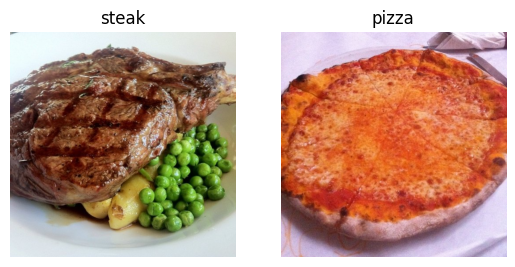

In [29]:
plt.figure()
plt.subplot(1, 2, 1)
dump = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
dump = view_random_image("pizza_steak/train/", "pizza")

## 2. Preprocess the data (prepare it for a model)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen  = ImageDataGenerator(rescale=1/255.)

train_data = train_data_gen.flow_from_directory(
    directory       = train_data_path,
    batch_size      = 32,
    target_size     = (224, 224),
    seed            = 42,
    class_mode      = "binary"
)

test_data  = test_data_gen.flow_from_directory(
    directory       = test_data_path,
    batch_size      = 1,
    target_size     = (224, 224),
    seed            = 42,
    class_mode      = "binary"
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


The train_data and test_data are generators. Then, to get a batch of images (32 for training and 1 for testing) we use next().

## 3. Create a CNN model (start with a baseline)

In [32]:
model_2 = Sequential([
    Conv2D(
        filters     = 10,
        kernel_size = (3,3),
        strides     = (1, 1),
        padding     = "valid",
        input_shape = (224, 224, 3),
        activation  = "relu"
    ),
    Conv2D(10, 3, 1, padding="valid", activation="relu"),
    MaxPool2D(),

    Conv2D(10, 3, 1, padding="valid", activation="relu"),
    Conv2D(10, 3, 1, padding="valid", activation="relu"),
    MaxPool2D(),

    Flatten(),

    Dense(1, activation="sigmoid")
])

In [33]:
model_2.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"],
    loss = "binary_crossentropy"
)

In [35]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [36]:
history_2 = model_2.fit(
    train_data,
    epochs           = 10,
    steps_per_epoch  = len(train_data),
    validation_data  = test_data,
    validation_steps = len(test_data)
)

Epoch 1/10
47/47 [==============================] - 67s 1s/step - loss: 0.5902 - accuracy: 0.6887 - val_loss: 0.4102 - val_accuracy: 0.8220
Epoch 2/10
47/47 [==============================] - 61s 1s/step - loss: 0.4572 - accuracy: 0.7887 - val_loss: 0.3820 - val_accuracy: 0.8420
Epoch 3/10
47/47 [==============================] - 62s 1s/step - loss: 0.4306 - accuracy: 0.8173 - val_loss: 0.3678 - val_accuracy: 0.8520
Epoch 4/10
47/47 [==============================] - 61s 1s/step - loss: 0.3940 - accuracy: 0.8213 - val_loss: 0.3455 - val_accuracy: 0.8600
Epoch 5/10
47/47 [==============================] - 63s 1s/step - loss: 0.3608 - accuracy: 0.8480 - val_loss: 0.3216 - val_accuracy: 0.8540
Epoch 6/10
47/47 [==============================] - 61s 1s/step - loss: 0.3497 - accuracy: 0.8480 - val_loss: 0.3402 - val_accuracy: 0.8420
Epoch 7/10
47/47 [==============================] - 62s 1s/step - loss: 0.2759 - accuracy: 0.8967 - val_loss: 0.3256 - val_accuracy: 0.8600
Epoch 8/10
47/47 [==

## 5. Evaluating our model

In [37]:
print(type(history_2.history))
print(history_2.history.keys())

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Axes: >

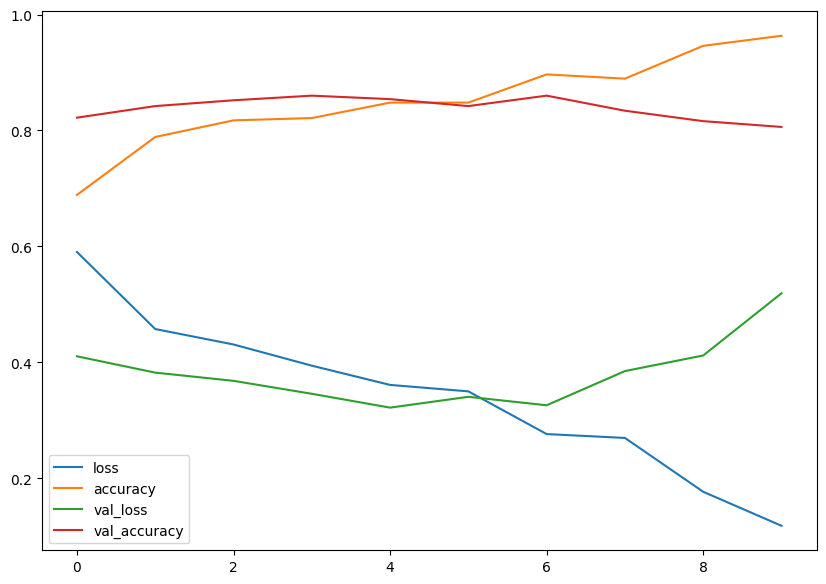

In [39]:
import pandas as pd
pd.DataFrame(history_2.history).plot(figsize=(10,7))

In [40]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

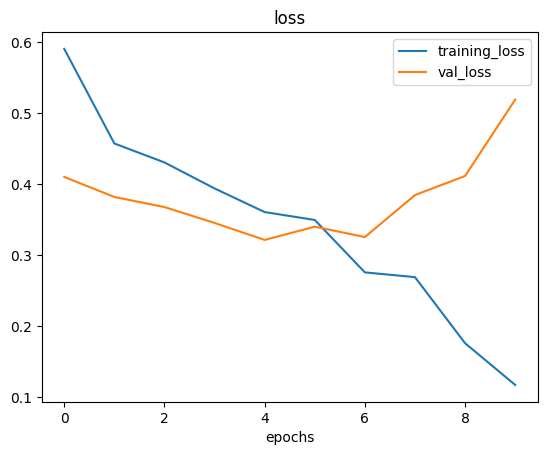

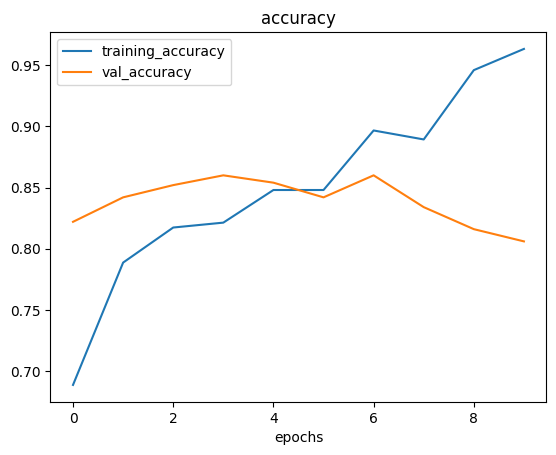

In [43]:
plot_loss_curves(history_2)

It seems we have overfitting whilst the epochs increase. We can use data augmentation to try breaking that behavior.

In [44]:
train_datagen_augmented = ImageDataGenerator(
    rescale             = 1/255.,
    rotation_range      = 0.2,
    shear_range         = 0.2,
    zoom_range          = 0.2,
    width_shift_range   = 0.2,
    height_shift_range  = 0.2,
    horizontal_flip     = True
)

train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory       = test_data_path,
    batch_size      = 16,
    target_size     = (224, 224),
    seed            = 42,
    class_mode      = "binary",
)

Found 500 images belonging to 2 classes.


In [45]:
history_2 = model_2.fit(
    train_data_augmented,
    epochs              = 10,
    steps_per_epoch     = len(train_data_augmented),
    validation_data     = test_data,
    validation_steps    = len(test_data)
)

Epoch 1/10
32/32 [==============================] - 36s 1s/step - loss: 0.5311 - accuracy: 0.7540 - val_loss: 0.4104 - val_accuracy: 0.8160
Epoch 2/10
32/32 [==============================] - 34s 1s/step - loss: 0.4611 - accuracy: 0.7880 - val_loss: 0.3241 - val_accuracy: 0.8460
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 0.4002 - accuracy: 0.8280 - val_loss: 0.2828 - val_accuracy: 0.8860
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 0.3740 - accuracy: 0.8200 - val_loss: 0.2851 - val_accuracy: 0.8800
Epoch 5/10
32/32 [==============================] - 33s 1s/step - loss: 0.3564 - accuracy: 0.8220 - val_loss: 0.2560 - val_accuracy: 0.8820
Epoch 6/10
32/32 [==============================] - 34s 1s/step - loss: 0.3681 - accuracy: 0.8440 - val_loss: 0.2517 - val_accuracy: 0.8980
Epoch 7/10
32/32 [==============================] - 33s 1s/step - loss: 0.3647 - accuracy: 0.8340 - val_loss: 0.2573 - val_accuracy: 0.8880
Epoch 8/10
32/32 [==

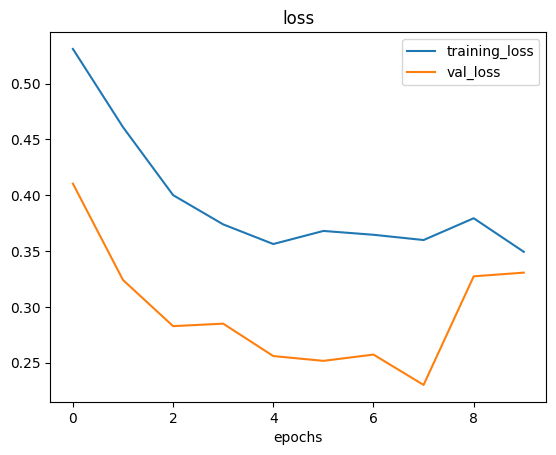

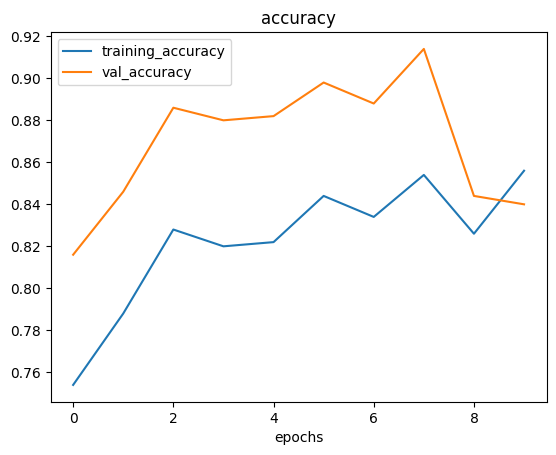

In [46]:
plot_loss_curves(history_2)

It seems to be better. Let's try to use the shuffle argument.

In [47]:
train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory       = test_data_path,
    batch_size      = 32,
    target_size     = (224, 224),
    seed            = 42,
    class_mode      = "binary",
    shuffle         = True
)

Found 500 images belonging to 2 classes.


In [48]:
history_2 = model_2.fit(
    train_data_augmented,
    epochs              = 10,
    steps_per_epoch     = len(train_data_augmented),
    validation_data     = test_data,
    validation_steps    = len(test_data)
)

Epoch 1/10
16/16 [==============================] - 34s 2s/step - loss: 0.3243 - accuracy: 0.8620 - val_loss: 0.2361 - val_accuracy: 0.9080
Epoch 2/10
16/16 [==============================] - 33s 2s/step - loss: 0.3230 - accuracy: 0.8600 - val_loss: 0.2524 - val_accuracy: 0.8880
Epoch 3/10
16/16 [==============================] - 33s 2s/step - loss: 0.2993 - accuracy: 0.8740 - val_loss: 0.2243 - val_accuracy: 0.9180
Epoch 4/10
16/16 [==============================] - 32s 2s/step - loss: 0.2984 - accuracy: 0.8900 - val_loss: 0.2266 - val_accuracy: 0.9040
Epoch 5/10
16/16 [==============================] - 34s 2s/step - loss: 0.3275 - accuracy: 0.8500 - val_loss: 0.2321 - val_accuracy: 0.9000
Epoch 6/10
16/16 [==============================] - 33s 2s/step - loss: 0.2879 - accuracy: 0.8780 - val_loss: 0.2912 - val_accuracy: 0.8760
Epoch 7/10
16/16 [==============================] - 32s 2s/step - loss: 0.2824 - accuracy: 0.8740 - val_loss: 0.2898 - val_accuracy: 0.8760
Epoch 8/10
16/16 [==

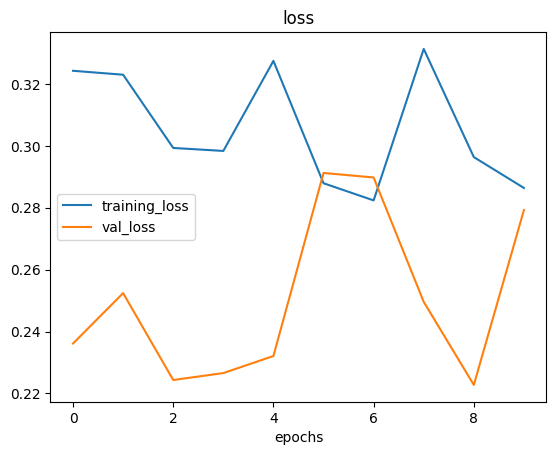

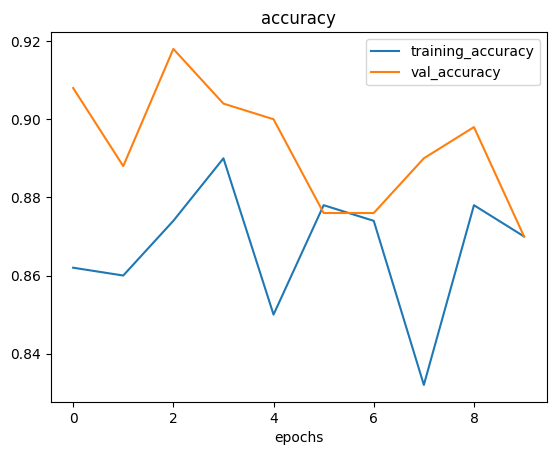

In [51]:
plot_loss_curves(history_2)

Just with the shuffle we got a very different result. It seems to be more convergent at 10 epochs. 

In [49]:
def predict_steak_or_pizza(img_path=None, url=None):
    img = load_and_prep_image(img_path, url)
    pred = model_2.predict(tf.expand_dims(img, axis=0))
    if pred > 0.5:
        print("You got a steak")
    else:
        print("You got a pizza")

In [50]:
# Only pizzas
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSYc4FDO-ZSCqCtWfpb7AX4RBYUvWXwGd1_aFAEjoyODVmMv0syOjNFoHSy0g6j5uU7Jes&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRnZMTxbiq-6Rk6w5wajajLa3eSApBkTHioMobQ54DBz_cnQliOe3OXYc_5dQof7qLZn3Q&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4hrnTXz5Dr4aVHN6xkb3hg85Q5F4z5Nxiboi8o176skOSZjlTHh99NkaDt8e-SqznwCs&usqp=CAU")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQLxpXTxE5QO4Y5S6FHQYiQ6-uf1Qwe6FHb28YDggeuamrPOUsIdP2Nt1OlY6sCZgJSYFI&usqp=CAU")
predict_steak_or_pizza(url="https://media-cdn.tripadvisor.com/media/photo-s/17/98/96/31/photo0jpg.jpg")
predict_steak_or_pizza(url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTyo8-Fg7Pa_8RQdKuLrWY6A5MQDIQgQxPuVTzA4Po8On3rMWl9I9NOY24WLIpHMOqUyss&usqp=CAU")

1/1 [==============================] - 0s 166ms/step
You got a pizza
1/1 [==============================] - 0s 89ms/step
You got a pizza
1/1 [==============================] - 0s 74ms/step
You got a pizza
1/1 [==============================] - 0s 84ms/step
You got a pizza
1/1 [==============================] - 0s 71ms/step
You got a steak
1/1 [==============================] - 0s 68ms/step
You got a steak


Now we got a 4/2. It's better! With a simple data augmentation, we increase the quality of our model.